In [1]:
from pathlib import Path
import torch
import seaborn as sn
import os
import sys

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
modules_dir = Path().absolute().parent
print(modules_dir)
sys.path.append(str(Path().absolute().parent))
sys.path.append(str(modules_dir))

/home/andrea/Project/ProfileModel


In [3]:
from data.preprocessing import MyDataset, PreprocessData
from config import ModelArgs
from training import TrainingPipeline
from utils.torch_utils import fix_random, get_device

from predict import InferencePipeline

In [4]:
seed = 89
fix_random(seed)

device = get_device()
fpath = "datasets/trx_data.csv"

Device: cuda


In [5]:
class2colors = {
             'TRX-1':'#674da7',
             'TRX-2':'#3c84c5',
             'TRX-3':'#43808d',
             'TRX-4':'#68a84e',
             'TRX-5':'#f0c030',
             'TRX-6':'#cc0000',
             'TRX-7':'#0c6c18',
             'TRX-8':'#a44c78'}

# TRX-1 A0A5A7MNT3
# TRX-2 L5LE17
# TRX-3 A0A833VMF7
# TRX-4 A0A445ASL5
# TRX-5 M4CYC0
# TRX-6 A0A1C0UXM5
# TRX-7 A0A7L2CD13
# TRX-8 A0A137PD51

In [6]:
# from cProfile import label
# import matplotlib.pyplot as plt

# class2counts = df.groupby(['group'])['group'].value_counts().to_dict()

# fig, ax = plt.subplots()

# for c, count in class2counts.items():
#     bar = ax.bar(c, count, label=c, color=class2colors[c])
#     ax.bar_label(bar)


# plt.xticks([])
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.show()

In [7]:
data, targets = PreprocessData(fpath).get_data()

dataset = MyDataset(data, targets)
dataset.split_data(seed, val_set=True, undersampling=False)

class2weights = dataset.compute_class_weights()
class_weights = torch.Tensor(list(class2weights.values()))

model_args = ModelArgs()
model_args.distinct_labels = dataset.labels
model_args.num_class = len(dataset.labels)

Weights per class: {0: 0.3197047132311187, 1: 2.0717571297148116, 2: 1.541409993155373, 3: 3.6147672552166936, 4: 1.778830963665087, 5: 1.2831908831908831, 6: 1.2759206798866856, 7: 0.7469320066334991}


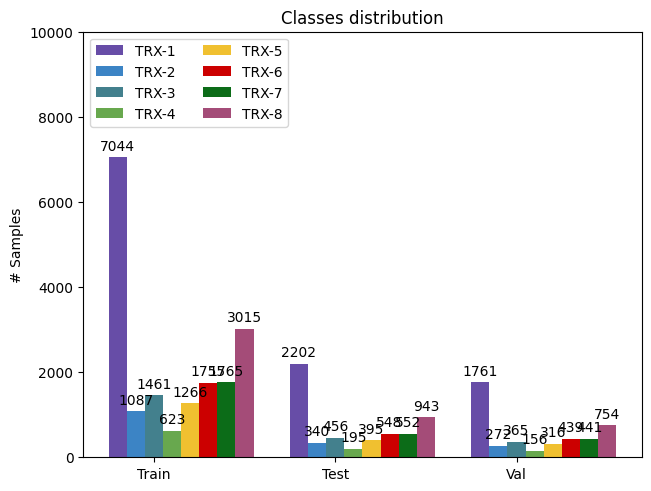

<Figure size 640x480 with 0 Axes>

In [8]:
dataset.plot_distribution(class2colors)

In [10]:
batch_size = 6

loaders_dict = dataset.get_data_loaders(
    model_name=model_args.esm_name, fpath=fpath, batch_size=batch_size
)

train_loader = loaders_dict['train_loader']
val_loader = loaders_dict['val_loader']
test_loader = loaders_dict['test_loader']

In [11]:
from config import TrainArgs
import datetime
import itertools

lora_alphas = [8,32]
lora_ranks = [8]
lora_dropout = [0.0]
w_decay = [1e-3]
lr_rates = [5e-5]
optimizers = [torch.optim.Adam, torch.optim.AdamW]

#dataset.split_data(seed, val_set=True, undersampling=False)

# class2weights = dataset.compute_class_weights()
# class_weights = torch.Tensor(list(class2weights.values()))

# loaders_dict = dataset.get_data_loaders(
# model_name=model_args.esm_name, fpath=fpath, batch_size=batch_size
# )

# train_loader = loaders_dict['train_loader']
# val_loader = loaders_dict['val_loader']
# test_loader = loaders_dict['test_loader']

for alpha, rank, drop, w_d, lr in itertools.product(lora_alphas, lora_ranks, lora_dropout, w_decay, lr_rates):

    date = datetime.datetime.now().strftime("%d-%m-%Y_%Hh%Mm")

    train_args = TrainArgs()
    train_args.nametrain = f"finetune_TRX_{date}_seed-{seed}_a-{alpha}_r-{rank}_d-{drop}w-{w_d}_lr{lr}"
    train_args.l_rate = lr
    train_args.epochs = 10
    train_args.criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device), label_smoothing=0.1)
    train_args.w_decay = 0.1
    #train_args.optimizer = opt

    model_args.lora_alpha = alpha
    model_args.lora_rank = rank
    model_args.lora_dropout = drop

    pipeline = TrainingPipeline(seed=seed, mode='manual', device=device)

    print(f"seed-{seed}_a-{alpha}_r-{rank}_d-{drop}w-{w_d}_lr{lr}")
    results = pipeline(
        train_loader=train_loader, val_loader=val_loader, model_args=model_args, train_args=train_args
        )

seed-89_a-8_r-8_d-0.0w-0.001_lr5e-05


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 511,208 || all params: 34,507,937 || trainable%: 1.4814215060146887


100%|██████████| 751/751 [02:34<00:00,  4.87it/s, lr=5e-5, val_loss=1.34, val_acc=0.68]


 Epoch: 0  Lr: 0.0000500  Loss: Train = [1.5993] - Val = [1.3386]  Accuracy: Train = [0.53%] - Val = [0.68%]  Time one epoch (s): 1713.7527 


100%|██████████| 751/751 [02:34<00:00,  4.87it/s, lr=5e-5, val_loss=1.17, val_acc=0.77]


 Epoch: 1  Lr: 0.0000500  Loss: Train = [1.2538] - Val = [1.1695]  Accuracy: Train = [0.73%] - Val = [0.77%]  Time one epoch (s): 1717.2856 


100%|██████████| 751/751 [02:34<00:00,  4.87it/s, lr=5e-5, val_loss=1.09, val_acc=0.81]


 Epoch: 2  Lr: 0.0000500  Loss: Train = [1.1276] - Val = [1.0943]  Accuracy: Train = [0.80%] - Val = [0.81%]  Time one epoch (s): 1717.1238 


100%|██████████| 751/751 [02:34<00:00,  4.87it/s, lr=5e-5, val_loss=1.06, val_acc=0.83]


 Epoch: 3  Lr: 0.0000500  Loss: Train = [1.0497] - Val = [1.0590]  Accuracy: Train = [0.84%] - Val = [0.83%]  Time one epoch (s): 1715.7227 


100%|██████████| 751/751 [02:34<00:00,  4.87it/s, lr=5e-5, val_loss=1.03, val_acc=0.84]


 Epoch: 4  Lr: 0.0000500  Loss: Train = [1.0024] - Val = [1.0341]  Accuracy: Train = [0.86%] - Val = [0.84%]  Time one epoch (s): 1715.2065 


100%|██████████| 751/751 [02:33<00:00,  4.88it/s, lr=5e-5, val_loss=1.03, val_acc=0.84]


 Epoch: 5  Lr: 0.0000500  Loss: Train = [0.9688] - Val = [1.0294]  Accuracy: Train = [0.88%] - Val = [0.84%]  Time one epoch (s): 1715.2636 


100%|██████████| 751/751 [02:34<00:00,  4.87it/s, lr=5e-5, val_loss=1.01, val_acc=0.86] 


 Epoch: 6  Lr: 0.0000500  Loss: Train = [0.9464] - Val = [1.0078]  Accuracy: Train = [0.89%] - Val = [0.86%]  Time one epoch (s): 1714.4465 


100%|██████████| 751/751 [02:34<00:00,  4.87it/s, lr=5e-5, val_loss=0.992, val_acc=0.87]


 Epoch: 7  Lr: 0.0000500  Loss: Train = [0.9197] - Val = [0.9916]  Accuracy: Train = [0.91%] - Val = [0.87%]  Time one epoch (s): 1715.6758 


100%|██████████| 751/751 [02:33<00:00,  4.88it/s, lr=5e-5, val_loss=1, val_acc=0.85]    


 Epoch: 8  Lr: 0.0000500  Loss: Train = [0.9013] - Val = [1.0000]  Accuracy: Train = [0.92%] - Val = [0.85%]  Time one epoch (s): 1714.7754 


100%|██████████| 751/751 [02:33<00:00,  4.88it/s, lr=5e-5, val_loss=1.01, val_acc=0.85] 


 Epoch: 9  Lr: 0.0000500  Loss: Train = [0.8793] - Val = [1.0116]  Accuracy: Train = [0.93%] - Val = [0.85%]  Time one epoch (s): 1714.3131 
Time for 10 epochs (s): 17154.445
Best acc: 0.87 epoch: 8.

seed-89_a-32_r-8_d-0.0w-0.001_lr5e-05


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 511,208 || all params: 34,507,937 || trainable%: 1.4814215060146887


100%|██████████| 751/751 [02:33<00:00,  4.88it/s, lr=5e-5, val_loss=1.17, val_acc=0.77]


 Epoch: 0  Lr: 0.0000500  Loss: Train = [1.4625] - Val = [1.1715]  Accuracy: Train = [0.60%] - Val = [0.77%]  Time one epoch (s): 1713.2981 


100%|██████████| 751/751 [02:34<00:00,  4.86it/s, lr=5e-5, val_loss=1.06, val_acc=0.84]


 Epoch: 1  Lr: 0.0000500  Loss: Train = [1.1104] - Val = [1.0602]  Accuracy: Train = [0.80%] - Val = [0.84%]  Time one epoch (s): 1715.4250 


100%|██████████| 751/751 [02:33<00:00,  4.88it/s, lr=5e-5, val_loss=1.01, val_acc=0.86] 


 Epoch: 2  Lr: 0.0000500  Loss: Train = [1.0197] - Val = [1.0077]  Accuracy: Train = [0.85%] - Val = [0.86%]  Time one epoch (s): 1713.7277 


100%|██████████| 751/751 [02:33<00:00,  4.89it/s, lr=5e-5, val_loss=0.985, val_acc=0.86]


 Epoch: 3  Lr: 0.0000500  Loss: Train = [0.9718] - Val = [0.9850]  Accuracy: Train = [0.88%] - Val = [0.86%]  Time one epoch (s): 1712.3419 


100%|██████████| 751/751 [02:34<00:00,  4.87it/s, lr=5e-5, val_loss=0.99, val_acc=0.86] 


 Epoch: 4  Lr: 0.0000500  Loss: Train = [0.9305] - Val = [0.9903]  Accuracy: Train = [0.90%] - Val = [0.86%]  Time one epoch (s): 1713.3434 


100%|██████████| 751/751 [02:33<00:00,  4.89it/s, lr=5e-5, val_loss=0.984, val_acc=0.87]


 Epoch: 5  Lr: 0.0000500  Loss: Train = [0.9031] - Val = [0.9840]  Accuracy: Train = [0.91%] - Val = [0.87%]  Time one epoch (s): 1713.4466 


100%|██████████| 751/751 [02:33<00:00,  4.88it/s, lr=5e-5, val_loss=0.972, val_acc=0.88]


 Epoch: 6  Lr: 0.0000500  Loss: Train = [0.8759] - Val = [0.9715]  Accuracy: Train = [0.93%] - Val = [0.88%]  Time one epoch (s): 1712.7873 


100%|██████████| 751/751 [02:33<00:00,  4.88it/s, lr=5e-5, val_loss=0.964, val_acc=0.88]


 Epoch: 7  Lr: 0.0000500  Loss: Train = [0.8561] - Val = [0.9636]  Accuracy: Train = [0.94%] - Val = [0.88%]  Time one epoch (s): 1713.9062 


100%|██████████| 751/751 [02:33<00:00,  4.88it/s, lr=5e-5, val_loss=0.994, val_acc=0.86]


 Epoch: 8  Lr: 0.0000500  Loss: Train = [0.8388] - Val = [0.9939]  Accuracy: Train = [0.95%] - Val = [0.86%]  Time one epoch (s): 1713.6465 


100%|██████████| 751/751 [02:33<00:00,  4.89it/s, lr=5e-5, val_loss=0.968, val_acc=0.88]

 Epoch: 9  Lr: 0.0000500  Loss: Train = [0.8201] - Val = [0.9681]  Accuracy: Train = [0.96%] - Val = [0.88%]  Time one epoch (s): 1712.6254 
Time for 10 epochs (s): 17135.430
Best acc: 0.88 epoch: 8.



### Load best setup

In [16]:
import json

fpath = "results/metrics/finetune_TRX_28-08-2024_21h19m_seed-89_a-32_r-4_d-0.1s-None_lr5e-05/finetune_TRX_28-08-2024_21h19m_seed-89_a-32_r-4_d-0.1s-None_lr5e-05-LR_5e-05-AdamW_metrics.json"

f = open(fpath,'r')

results = json.load(f)
f.close()

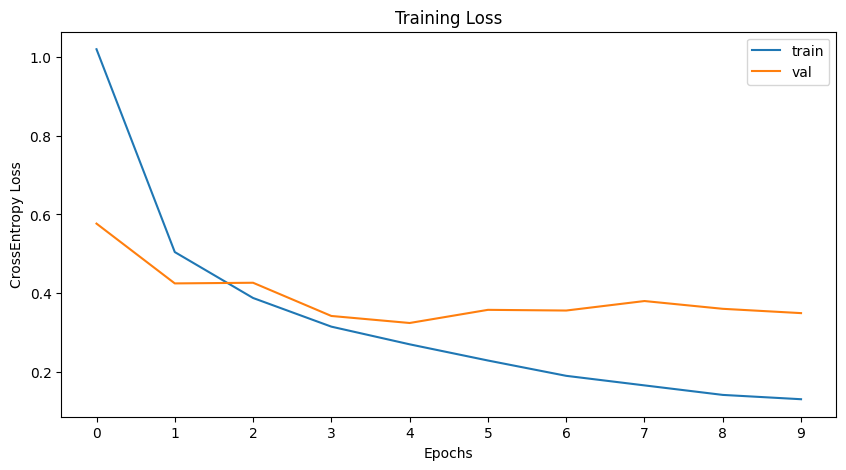

<Figure size 640x480 with 0 Axes>

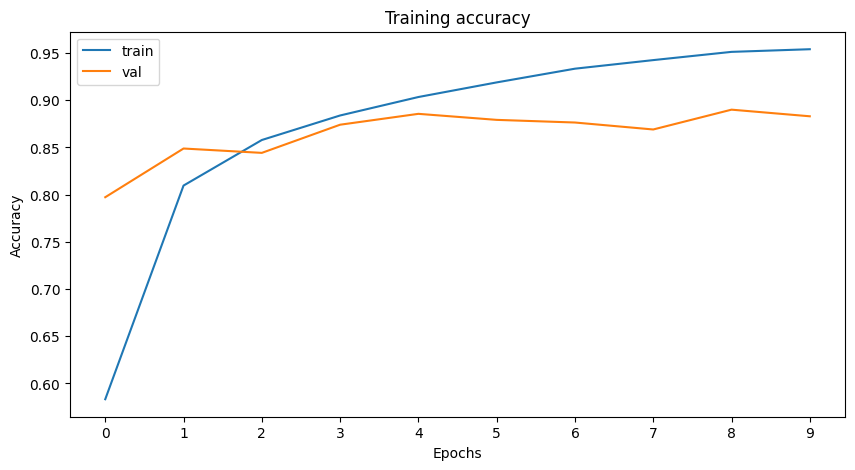

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

def plot_training_statistics(x, y, xlabel, ylabel, title, legend=None):

    plt.figure(figsize=(10,5))

    if legend is not None and isinstance(x,tuple) and isinstance(y,tuple):
        
        for leg, ix, iy in zip (legend,x,y):

            plt.plot(ix, iy, linestyle='-', label=leg)
        
        plt.xticks(x[0])
    else:

        plt.plot(x, y, linestyle='-')
        plt.xticks(x)
    
    plt.title(title)
    plt.xticks()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
    plt.clf()

num_epochs = len(results['train_loss'])

plot_training_statistics(
    (range(num_epochs),range(num_epochs)), (results['train_loss'],results['val_loss']), 'Epochs', "CrossEntropy Loss", "Training Loss", legend=['train','val']
    )
plot_training_statistics(
    (range(num_epochs),range(num_epochs)), (results['train_acc'],results['val_acc']), 'Epochs', "Accuracy", "Training accuracy", legend=['train','val']
    )

In [14]:
ckpt = torch.load("results/checkpoints/finetune_TRX_30-08-2024_05h45m_seed-89_a-32_r-8_d-0.0w-0.001_lr5e-05/LR_5e-05-Epoch_6-Val_0.88.tar")

config = ckpt['config']
lora_config = config['lora_config']['default']
lora_config.to_dict()

{'peft_type': <PeftType.LORA: 'LORA'>,
 'auto_mapping': None,
 'base_model_name_or_path': 'facebook/esm2_t12_35M_UR50D',
 'revision': None,
 'task_type': <TaskType.SEQ_CLS: 'SEQ_CLS'>,
 'inference_mode': False,
 'r': 8,
 'target_modules': {'key', 'query', 'value'},
 'lora_alpha': 32,
 'lora_dropout': 0.0,
 'fan_in_fan_out': False,
 'bias': 'none',
 'use_rslora': False,
 'modules_to_save': None,
 'init_lora_weights': True,
 'layers_to_transform': None,
 'layers_pattern': None,
 'rank_pattern': {},
 'alpha_pattern': {},
 'megatron_config': None,
 'megatron_core': 'megatron.core',
 'loftq_config': {},
 'use_dora': False,
 'layer_replication': None}

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 372,968 || all params: 34,369,697 || trainable%: 1.0851652256346629


100%|██████████| 939/939 [03:09<00:00,  4.95it/s, accuracy=0.88]


total time (s): 189.9031 - Single sample time (s): 0.0337


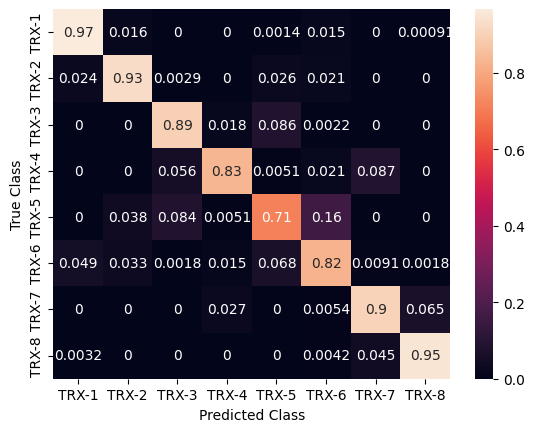

<Figure size 640x480 with 0 Axes>

In [11]:
from settings import BASE_PATH


pipeline = InferencePipeline(device=device)

ckpt_path = "notebooks/results/checkpoints/finetune_TRX_23-08-2024_20h50m_seed-89_a-32_r-4_d-0.1s-cosine_lr0.0001/LR_1.045974728736438e-05-Epoch_3-Val_0.89.tar"
predictions = pipeline(
    data_in=test_loader, model_in=ckpt_path, save=False, verbose=True
    )

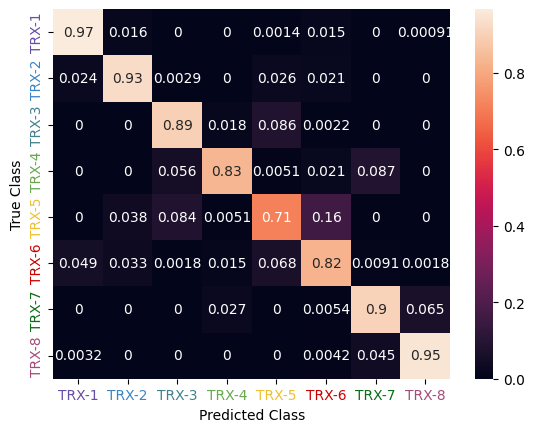

,TRX-1,TRX-2,TRX-3,TRX-4,TRX-5,TRX-6,TRX-7,TRX-8
TRX-1,0.965940,0.016349,0.000000,0.000000,0.001362,0.015441,0.000000,0.000908
TRX-2,0.023529,0.926471,0.002941,0.000000,0.026471,0.020588,0.000000,0.000000
TRX-3,0.000000,0.000000,0.894737,0.017544,0.085526,0.002193,0.000000,0.000000
TRX-4,0.000000,0.000000,0.056410,0.830769,0.005128,0.020513,0.087179,0.000000
TRX-5,0.000000,0.037975,0.083544,0.005063,0.711392,0.162025,0.000000,0.000000
TRX-6,0.049270,0.032847,0.001825,0.014599,0.067518,0.822993,0.009124,0.001825
TRX-7,0.000000,0.000000,0.000000,0.027174,0.000000,0.005435,0.902174,0.065217
TRX-8,0.003181,0.000000,0.000000,0.000000,0.000000,0.004242,0.044539,0.948038


<Figure size 640x480 with 0 Axes>

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

from utils.evaluation_utils import build_confusion_matrix


build_confusion_matrix(
    predictions['y_true'], predictions['y_pred'], dataset.labels, color_map=class2colors, verbose=True
    )

In [13]:
print(classification_report(predictions['y_true'], predictions['y_pred'], sample_weight=None,target_names=dataset.labels))

              precision    recall  f1-score   support

       TRX-1       0.98      0.97      0.97      2202
       TRX-2       0.82      0.93      0.87       340
       TRX-3       0.90      0.89      0.90       456
       TRX-4       0.83      0.83      0.83       195
       TRX-5       0.76      0.71      0.73       395
       TRX-6       0.79      0.82      0.81       548
       TRX-7       0.89      0.90      0.89       552
       TRX-8       0.96      0.95      0.95       943

    accuracy                           0.91      5631
   macro avg       0.87      0.88      0.87      5631
weighted avg       0.91      0.91      0.91      5631



In [14]:
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score


y_true = label_binarize(predictions['y_true'], classes=range(len(class_weights)))
n_classes = y_true.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):


    fpr[i], tpr[i], _ = roc_curve(y_true[:,i], np.array(predictions['y_prob'])[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), np.array(predictions['y_prob']).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

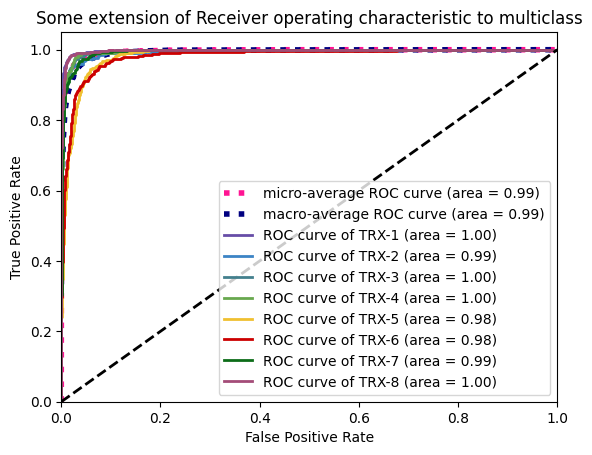

In [15]:
n_classes = len(class2weights)

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class2weights))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        color=class2colors[f"TRX-{i+1}"],
        lw=2,
        label="ROC curve of TRX-{0} (area = {1:0.2f})".format(i+1, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [9]:
import numpy as np
import pandas as pd

df = pd.DataFrame({'a': np.random.rand(10), 'b': np.random.rand(10)})

df.iloc[[0,2,4,6,8,9]].reset_index(names=['old_index'])

,old_index,a,b
0,0,0.821493,0.423591
1,2,0.967836,0.838929
2,4,0.694957,0.144022
3,6,0.742623,0.377913
4,8,0.658101,0.423814
5,9,0.057371,0.082723


In [18]:
np.nonzero(df['a'] < 0.5)[0]

array([1, 9])